# Preprocesamiento de datos

Importar las bibliotecas necesarias:

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import random

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Leer y cargar el conjunto de datos:

In [2]:
client = pymongo.MongoClient('mongodb://localhost:27017/', serverSelectionTimeoutMS=5000)

try:   
    print(client.start_session)
    dbSiedco = client.siedco
    dfDelitos = pd.DataFrame(list(dbSiedco.DelitosPrepro.find()))

    
except Exception:
    print("Unable to connect to the server.")

<bound method MongoClient.start_session of MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, serverselectiontimeoutms=5000)>


In [3]:
dfDelitosNew = dfDelitos.copy()
# Eliminar columnas
dfDelitosNew.drop(['_id'], axis=1, inplace=True)
# Cambiamos los tipos de datos de los atributos
dfDelitosNew['Anio'] = dfDelitosNew['Anio'].astype(int)
dfDelitosNew['Mes'] = dfDelitosNew['Mes'].astype(int)
dfDelitosNew['Dia'] = dfDelitosNew['Dia'].astype(int)
dfDelitosNew['Rango_Dia'] = dfDelitosNew['Rango_Dia'].astype('category')
dfDelitosNew['Localidad'] = dfDelitosNew['Localidad'].astype('category')
dfDelitosNew['UPZ'] = dfDelitosNew['UPZ'].astype('category')
dfDelitosNew['Sexo'] = dfDelitosNew['Sexo'].astype('category')
dfDelitosNew['Delito'] = dfDelitosNew['Delito'].astype('category')
dfDelitosNew['Modalidad'] = dfDelitosNew['Modalidad'].astype('category')
dfDelitosNew['Arma_Empleada'] = dfDelitosNew['Arma_Empleada'].astype('category')
dfDelitosNew['Numero_Hechos'] = dfDelitosNew['Numero_Hechos'].astype(int)


# Tecnica One-hot

In [4]:
most_frequent = dfDelitosNew['Sexo'].value_counts().idxmax()
dfDelitosNew['Sexo'] = dfDelitosNew['Sexo'].replace('NO REPORTADO', most_frequent)

In [5]:
datos_unicos = dfDelitosNew["Sexo"].unique()
tabla_datos = [{"Sexo": dato} for dato in datos_unicos]

tabla_formato = tabulate(tabla_datos, headers='keys', tablefmt='simple')

print(tabla_formato)

Sexo
---------
MASCULINO
FEMENINO


## Se aplica one-hot a las variables que tienen menor numero de categorias

In [6]:
# 'Sexo'
dfDelitosNew = pd.get_dummies(dfDelitosNew, columns=['Sexo'])
# 'Rango_Dia'
dfDelitosNew = pd.get_dummies(dfDelitosNew, columns=['Rango_Dia'])

In [7]:
dfDelitosNew[['Sexo_FEMENINO', 'Sexo_MASCULINO','Rango_Dia_MADRUGADA','Rango_Dia_MAÑANA','Rango_Dia_NOCHE','Rango_Dia_TARDE']].head()

,Sexo_FEMENINO,Sexo_MASCULINO,Rango_Dia_MADRUGADA,Rango_Dia_MAÑANA,Rango_Dia_NOCHE,Rango_Dia_TARDE
0,0,1,1,0,0,0
1,1,0,1,0,0,0
2,0,1,1,0,0,0
3,1,0,1,0,0,0
4,1,0,1,0,0,0


# Codificación de frecuencias

UPZ       		category --> 125
Modalidad 		category --> 129

In [8]:
# Calcular las frecuencias de las categorías en las variables 'UPZ' y 'Modalidad'
upz_freq = dfDelitosNew['UPZ'].value_counts(normalize=True)
modalidad_freq = dfDelitosNew['Modalidad'].value_counts(normalize=True)

# Aplicar la codificación de frecuencias a las variables 'UPZ' y 'Modalidad'
dfDelitosNew['UPZ'] = dfDelitosNew['UPZ'].map(upz_freq)
dfDelitosNew['Modalidad'] = dfDelitosNew['Modalidad'].map(modalidad_freq)

In [9]:
dfDelitosNew[['UPZ', 'Modalidad']].head()

,UPZ,Modalidad
0,0.013821,0.174212
1,0.005402,0.141828
2,0.005402,0.141828
3,0.013729,0.017777
4,0.006923,0.141828


In [10]:
dfDelitosNew[['UPZ', 'Modalidad']].describe()

,UPZ,Modalidad
count,1.090440e+06,1.090440e+06
mean,1.252933e-02,1.482498e-01
std,6.464144e-03,9.078152e-02
min,3.301420e-05,9.170610e-07
25%,7.542827e-03,8.069128e-02
50%,1.139448e-02,1.418281e-01
75%,1.605957e-02,2.721296e-01
max,2.743480e-02,2.721296e-01


# Codificación de enteros

In [11]:
# Crear un objeto LabelEncoder
le_delito = LabelEncoder()

# Hacer una copia del DataFrame original
dfDelitosNew_copy = dfDelitosNew.copy()

# Aplicar la codificación de enteros a la variable 'Delito' en la copia del DataFrame
dfDelitosNew_copy['Delito'] = le_delito.fit_transform(dfDelitosNew_copy['Delito'])

# Mostrar las etiquetas originales y las codificaciones correspondientes
for i, clase in enumerate(le_delito.classes_):
    print(f"{clase}: {i}")

AMENAZAS: 0
DELITOS SEXUALES: 1
EXTORSION: 2
HOMICIDIOS: 3
HOMICIDIOS EN ACCIDENTES DE TRANSITO: 4
HURTO A COMERCIO: 5
HURTO A ENTIDADES FINANCIERAS: 6
HURTO A PERSONAS: 7
HURTO A RESIDENCIAS: 8
HURTO ABIGEATO: 9
HURTO AUTOMOTORES: 10
HURTO DE BICICLETAS: 11
HURTO DE CELULARES: 12
HURTO MOTOCICLETAS: 13
HURTO PIRATERIA TERRESTRE: 14
LESIONES EN ACCIDENTES DE TRANSITO: 15
LESIONES PERSONALES: 16
SECUESTRO: 17
TERRORISMO: 18
VIOLENCIA INTRAFAMILIAR: 19


In [12]:
# Crear un objeto LabelEncoder
le_localidad = LabelEncoder()
dfDelitosNew['Localidad'] = le_localidad.fit_transform(dfDelitosNew['Localidad'])

le_delito = LabelEncoder()
dfDelitosNew['Delito'] = le_delito.fit_transform(dfDelitosNew['Delito'])

le_arma = LabelEncoder()
dfDelitosNew['Arma_Empleada'] = le_arma.fit_transform(dfDelitosNew['Arma_Empleada'])

In [13]:
dfDelitosNew[['Localidad', 'Delito', 'Arma_Empleada']]

,Localidad,Delito,Arma_Empleada
0,0,7,37
1,0,19,28
2,0,19,28
3,0,8,37
4,0,19,28
...,...,...,...
1090435,15,1,37
1090436,17,7,28
1090437,17,13,22
1090438,18,10,22


# Normalización de Datos

In [14]:
dfDelitosNew[['Anio', 'Mes', 'Dia']].describe()

,Anio,Mes,Dia
count,1.090440e+06,1.090440e+06,1.090440e+06
mean,2.020632e+03,6.488083e+00,1.563704e+01
std,1.222606e+00,3.546302e+00,8.825201e+00
min,2.019000e+03,1.000000e+00,1.000000e+00
25%,2.019000e+03,3.000000e+00,8.000000e+00
50%,2.021000e+03,7.000000e+00,1.600000e+01
75%,2.022000e+03,1.000000e+01,2.300000e+01
max,2.023000e+03,1.200000e+01,3.100000e+01


In [15]:
# Crear una instancia de la clase MinMaxScaler
scaler = MinMaxScaler()

# Ajustar el escalador a las columnas que deseas normalizar y transformarlas
dfDelitosNew[['Anio', 'Mes', 'Dia']] = scaler.fit_transform(dfDelitosNew[['Anio', 'Mes', 'Dia']])

In [16]:
dfDelitosNew[['Anio', 'Mes', 'Dia']].describe()

,Anio,Mes,Dia
count,1.090440e+06,1.090440e+06,1.090440e+06
mean,4.080417e-01,4.989166e-01,4.879014e-01
std,3.056515e-01,3.223911e-01,2.941734e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.818182e-01,2.333333e-01
50%,5.000000e-01,5.454545e-01,5.000000e-01
75%,7.500000e-01,8.181818e-01,7.333333e-01
max,1.000000e+00,1.000000e+00,1.000000e+00


In [17]:
# Eliminar columnas
dfDelitosNew.drop(['AnioMes'], axis=1, inplace=True)

In [18]:
dfDelitosNew

,Anio,Mes,Dia,Fecha,Localidad,UPZ,Delito,Modalidad,Arma_Empleada,Numero_Hechos,Sexo_FEMENINO,Sexo_MASCULINO,Rango_Dia_MADRUGADA,Rango_Dia_MAÑANA,Rango_Dia_NOCHE,Rango_Dia_TARDE
0,0.0,0.000000,0.0,2019-01-01,0,0.013821,7,0.174212,37,1,0,1,1,0,0,0
1,0.0,0.000000,0.0,2019-01-01,0,0.005402,19,0.141828,28,1,1,0,1,0,0,0
2,0.0,0.000000,0.0,2019-01-01,0,0.005402,19,0.141828,28,1,0,1,1,0,0,0
3,0.0,0.000000,0.0,2019-01-01,0,0.013729,8,0.017777,37,1,1,0,1,0,0,0
4,0.0,0.000000,0.0,2019-01-01,0,0.006923,19,0.141828,28,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090435,1.0,0.090909,0.9,2023-02-28,15,0.008891,1,0.141828,37,1,1,0,0,0,0,1
1090436,1.0,0.090909,0.9,2023-02-28,17,0.005331,7,0.272130,28,1,0,1,0,0,0,1
1090437,1.0,0.090909,0.9,2023-02-28,17,0.008333,13,0.027938,22,1,0,1,0,0,0,1
1090438,1.0,0.090909,0.9,2023-02-28,18,0.008019,10,0.027938,22,1,0,1,0,0,0,1


# Construcción de Secuencias Temporales 

Paso 1. Ordenar los datos cronológicamente

In [19]:
dfDelitosNew.sort_values('Fecha', inplace=True)
# Mostrar las primeras fechas ordenadas
first_dates = dfDelitosNew['Fecha'].drop_duplicates().head().tolist()
print("Primeras fechas ordenadas:")
print(tabulate({"Fecha": first_dates}, headers="keys", tablefmt="fancy_grid"))

# Mostrar las últimas fechas ordenadas
last_dates = dfDelitosNew['Fecha'].drop_duplicates().tail().tolist()
print("Últimas fechas ordenadas:")
print(tabulate({"Fecha": last_dates}, headers="keys", tablefmt="fancy_grid"))

Primeras fechas ordenadas:
╒═════════════════════╕
│ Fecha               │
╞═════════════════════╡
│ 2019-01-01 00:00:00 │
├─────────────────────┤
│ 2019-01-02 00:00:00 │
├─────────────────────┤
│ 2019-01-03 00:00:00 │
├─────────────────────┤
│ 2019-01-04 00:00:00 │
├─────────────────────┤
│ 2019-01-05 00:00:00 │
╘═════════════════════╛
Últimas fechas ordenadas:
╒═════════════════════╕
│ Fecha               │
╞═════════════════════╡
│ 2023-02-24 00:00:00 │
├─────────────────────┤
│ 2023-02-25 00:00:00 │
├─────────────────────┤
│ 2023-02-26 00:00:00 │
├─────────────────────┤
│ 2023-02-27 00:00:00 │
├─────────────────────┤
│ 2023-02-28 00:00:00 │
╘═════════════════════╛


Paso 2: Agregación de los datos al nivel de día

In [20]:
# Agrupar por fecha y contar registros
count_by_date = dfDelitosNew.groupby('Fecha').size().reset_index(name='Cantidad')

# Obtener los primeros 5 registros
primeros_5 = count_by_date.head(5)

# Obtener los últimos 5 registros
ultimos_5 = count_by_date.tail(5)

# Mostrar los primeros 5 registros con tabulate
print("Primeros 5 registros:")
print(tabulate(primeros_5, headers='keys', tablefmt='fancy_grid'))

# Mostrar los últimos 5 registros con tabulate
print("Últimos 5 registros:")
print(tabulate(ultimos_5, headers='keys', tablefmt='fancy_grid'))

Primeros 5 registros:
╒════╤═════════════════════╤════════════╕
│    │ Fecha               │   Cantidad │
╞════╪═════════════════════╪════════════╡
│  0 │ 2019-01-01 00:00:00 │        443 │
├────┼─────────────────────┼────────────┤
│  1 │ 2019-01-02 00:00:00 │        392 │
├────┼─────────────────────┼────────────┤
│  2 │ 2019-01-03 00:00:00 │        492 │
├────┼─────────────────────┼────────────┤
│  3 │ 2019-01-04 00:00:00 │        524 │
├────┼─────────────────────┼────────────┤
│  4 │ 2019-01-05 00:00:00 │        494 │
╘════╧═════════════════════╧════════════╛
Últimos 5 registros:
╒══════╤═════════════════════╤════════════╕
│      │ Fecha               │   Cantidad │
╞══════╪═════════════════════╪════════════╡
│ 1515 │ 2023-02-24 00:00:00 │        246 │
├──────┼─────────────────────┼────────────┤
│ 1516 │ 2023-02-25 00:00:00 │        249 │
├──────┼─────────────────────┼────────────┤
│ 1517 │ 2023-02-26 00:00:00 │        260 │
├──────┼─────────────────────┼────────────┤
│ 1518 │ 2023-0

In [21]:
dfDelitosNew_daily = dfDelitosNew.groupby('Fecha').mean()
dfDelitosNew_daily.head()

,Anio,Mes,Dia,Localidad,UPZ,Delito,Modalidad,Arma_Empleada,Numero_Hechos,Sexo_FEMENINO,Sexo_MASCULINO,Rango_Dia_MADRUGADA,Rango_Dia_MAÑANA,Rango_Dia_NOCHE,Rango_Dia_TARDE
Fecha,,,,,,,,,,,,,,,
2019-01-01,0.0,0.0,0.000000,8.747178,0.011917,11.510158,0.115489,21.539503,1.054176,0.458239,0.541761,0.519187,0.182844,0.176072,0.121896
2019-01-02,0.0,0.0,0.033333,8.757653,0.011972,9.780612,0.139180,22.206633,1.020408,0.410714,0.589286,0.372449,0.214286,0.198980,0.214286
2019-01-03,0.0,0.0,0.066667,9.087398,0.012065,10.355691,0.146335,21.792683,1.028455,0.453252,0.546748,0.416667,0.172764,0.231707,0.178862
2019-01-04,0.0,0.0,0.100000,8.748092,0.012656,9.322519,0.144432,22.679389,1.028626,0.393130,0.606870,0.469466,0.192748,0.175573,0.162214
2019-01-05,0.0,0.0,0.133333,8.212551,0.012110,9.645749,0.142939,23.028340,1.010121,0.443320,0.556680,0.419028,0.153846,0.230769,0.196356


Paso 3: Selección de las columnas relevantes

In [22]:
relevant_columns = ['Anio', 'Mes', 'Dia', 'Localidad', 'UPZ', 'Delito', 'Modalidad', 'Arma_Empleada', 'Numero_Hechos', 
                    'Sexo_FEMENINO', 'Sexo_MASCULINO', 'Rango_Dia_MADRUGADA', 'Rango_Dia_MAÑANA', 'Rango_Dia_NOCHE', 
                    'Rango_Dia_TARDE']
dfDelitosNew_relevant = dfDelitosNew_daily[relevant_columns]

In [40]:
dfDelitosNew_relevant.head()

,Anio,Mes,Dia,Localidad,UPZ,Delito,Modalidad,Arma_Empleada,Numero_Hechos,Sexo_FEMENINO,Sexo_MASCULINO,Rango_Dia_MADRUGADA,Rango_Dia_MAÑANA,Rango_Dia_NOCHE,Rango_Dia_TARDE
Fecha,,,,,,,,,,,,,,,
2019-01-01,0.0,0.0,0.000000,8.747178,0.011917,11.510158,0.115489,21.539503,1.054176,0.458239,0.541761,0.519187,0.182844,0.176072,0.121896
2019-01-02,0.0,0.0,0.033333,8.757653,0.011972,9.780612,0.139180,22.206633,1.020408,0.410714,0.589286,0.372449,0.214286,0.198980,0.214286
2019-01-03,0.0,0.0,0.066667,9.087398,0.012065,10.355691,0.146335,21.792683,1.028455,0.453252,0.546748,0.416667,0.172764,0.231707,0.178862
2019-01-04,0.0,0.0,0.100000,8.748092,0.012656,9.322519,0.144432,22.679389,1.028626,0.393130,0.606870,0.469466,0.192748,0.175573,0.162214
2019-01-05,0.0,0.0,0.133333,8.212551,0.012110,9.645749,0.142939,23.028340,1.010121,0.443320,0.556680,0.419028,0.153846,0.230769,0.196356


Paso 4: Definición del tamaño de la ventana temporal

In [23]:
lookback = 30  # Tamaño de la ventana temporal

Paso 5: Creación de las secuencias temporales

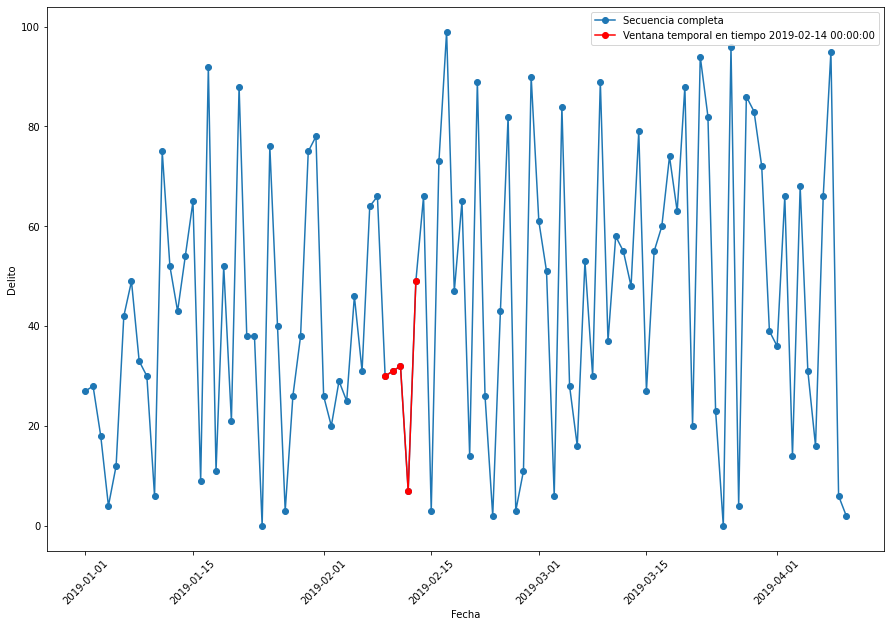

In [24]:
# Supongamos que 'dfDelitosNew' es tu DataFrame y ya está indexado por 'Fecha'
dfDelitosNewS = dfDelitosNew.copy()
dfDelitosNewS = pd.DataFrame(np.random.randint(0,100,size=(100, 1)), columns=['Delito'], 
                            index=pd.date_range(start='1/1/2019', periods=100))

# Define el tamaño de la ventana temporal
lookback_ejemplo = 5

# Define el tiempo actual t
t = pd.Timestamp('2019-02-14')

# Crea una figura y un eje de mayor tamaño
fig, ax = plt.subplots(figsize=(15, 10))  # Ajusta el tamaño a lo que necesites

# Dibuja la secuencia completa
ax.plot(dfDelitosNewS.index, dfDelitosNewS['Delito'], '-o', label='Secuencia completa')

# Dibuja la ventana temporal en el tiempo t
ax.plot(dfDelitosNewS.loc[t - pd.Timedelta(days=lookback_ejemplo):t - pd.Timedelta(days=1)].index, 
        dfDelitosNewS.loc[t - pd.Timedelta(days=lookback_ejemplo):t - pd.Timedelta(days=1)]['Delito'], 
        '-o', color='red', label=f'Ventana temporal en tiempo {t}')

# Añade una leyenda
ax.legend()

# Añade etiquetas a los ejes
ax.set_xlabel('Fecha')
ax.set_ylabel('Delito')

# Ajusta la orientación de las etiquetas del eje x
plt.xticks(rotation=45)

# Muestra la gráfica
plt.show()

Funcion Secuencia temporal

In [29]:
def create_sequences(df, lookback):
    X, y = [], []
    for i in range(len(df) - lookback):
        X.append(df.iloc[i:(i + lookback)].values)
        y.append(df.iloc[i + lookback].values)
    return np.array(X), np.array(y)

In [31]:
X, y = create_sequences(dfDelitosNew_relevant, lookback)

print("Secuencias de entrada (X):")
print(X)

print("Salidas correspondientes (y):")
print(y)

Secuencias de entrada (X):
[[[0.         0.         0.         ... 0.18284424 0.17607223 0.12189616]
  [0.         0.         0.03333333 ... 0.21428571 0.19897959 0.21428571]
  [0.         0.         0.06666667 ... 0.17276423 0.23170732 0.17886179]
  ...
  [0.         0.         0.9        ... 0.21595598 0.1911967  0.1911967 ]
  [0.         0.         0.93333333 ... 0.19899875 0.19274093 0.19148936]
  [0.         0.         0.96666667 ... 0.19166667 0.19761905 0.2       ]]

 [[0.         0.         0.03333333 ... 0.21428571 0.19897959 0.21428571]
  [0.         0.         0.06666667 ... 0.17276423 0.23170732 0.17886179]
  [0.         0.         0.1        ... 0.19274809 0.17557252 0.16221374]
  ...
  [0.         0.         0.93333333 ... 0.19899875 0.19274093 0.19148936]
  [0.         0.         0.96666667 ... 0.19166667 0.19761905 0.2       ]
  [0.         0.         1.         ... 0.18562874 0.20718563 0.16167665]]

 [[0.         0.         0.06666667 ... 0.17276423 0.23170732 0.17886

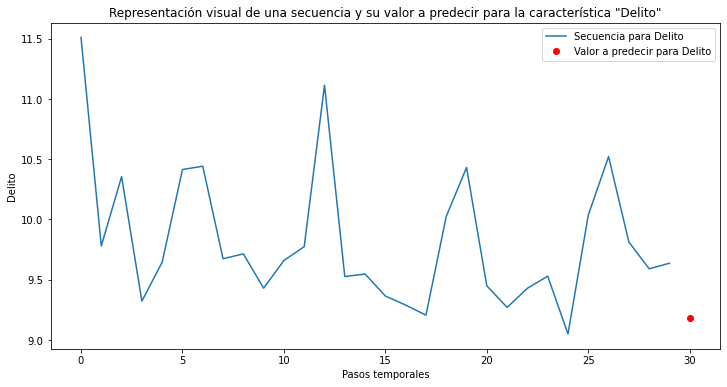

In [33]:
# Asumiendo que i es el índice de la secuencia que queremos visualizar
i = 0

# Asumiendo que 'Delito' es la característica que queremos visualizar
feature_index = dfDelitosNew_relevant.columns.tolist().index('Delito')

plt.figure(figsize=(12,6))
plt.plot(range(len(X[i, :, feature_index])), X[i, :, feature_index], label='Secuencia para Delito')
plt.plot(len(X[i, :, feature_index]), y[i, feature_index], 'ro', label='Valor a predecir para Delito')
plt.xlabel('Pasos temporales')
plt.ylabel('Delito')
plt.title('Representación visual de una secuencia y su valor a predecir para la característica "Delito"')
plt.legend()
plt.show()


# División de los datos

In [34]:
# Tamaño de los datos
data_size = len(X)

# Tamaños de los conjuntos de entrenamiento, validación y prueba
train_size = int(data_size * 0.7)
val_size = int(data_size * 0.15)

# Tamaños acumulados para utilizar en la división de los datos
train_val_size = train_size + val_size 

# División de los datos
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_val_size], y[train_size:train_val_size]
X_test, y_test = X[train_val_size:], y[train_val_size:]

In [35]:
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (1043, 30, 15)
Forma de X_val: (223, 30, 15)
Forma de X_test: (224, 30, 15)
Forma de y_train: (1043, 15)
Forma de y_val: (223, 15)
Forma de y_test: (224, 15)


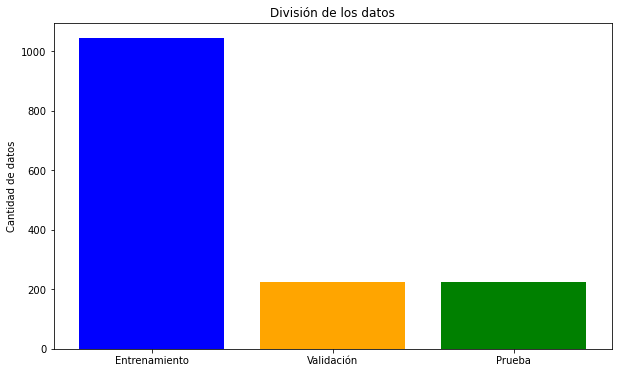

In [36]:
# Cantidad de datos en cada conjunto
data_counts = [len(X_train), len(X_val), len(X_test)]

# Creación del gráfico
plt.figure(figsize=(10, 6))
plt.bar(['Entrenamiento', 'Validación', 'Prueba'], data_counts, color=['blue', 'orange', 'green'])

# Etiquetas y título
plt.ylabel('Cantidad de datos')
plt.title('División de los datos')

# Mostrar el gráfico
plt.show()

## Definición del Modelo

Paso 1: Configuración de la arquitectura de la RNN

In [37]:
def build_model(input_shape):
    """
    Construye y retorna un modelo de red LSTM.
    
    Parameters:
    input_shape (tuple): Forma de los datos de entrada, por lo general (lookback, numero_de_caracteristicas).
    
    Returns:
    model (Sequential): Modelo de red LSTM.
    """
    
    model = Sequential()
    
    # Capa LSTM
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))

    # Capa LSTM adicional
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))

    # Capa densa
    model.add(Dense(32, activation='relu'))
    
    # Capa de salida
    model.add(Dense(1, activation='linear'))

    return model

# Crear el modelo
lookback = 30  # número de pasos temporales a mirar hacia atrás
num_features = dfDelitosNew_relevant.shape[1]  # número de características en los datos
model = build_model((lookback, num_features))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Mostrar el resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            13200     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 35,065
Trainable params: 35,065
Non-traina

Este es un resumen de la arquitectura del modelo de red neuronal recurrente (RNN) utilizado para predecir las incidencias de delitos en Bogotá. Aquí, cada línea representa una capa en la red, incluyendo su tipo, su salida y el número de parámetros entrenables.

Capa LSTM (lstm): Esta es la primera capa LSTM en la red. Esta capa procesa la secuencia de entrada y genera una secuencia de salida de la misma longitud (30, que es el número de pasos de tiempo en cada muestra) con 50 características en cada paso de tiempo. Esta capa tiene 13,200 parámetros entrenables.

Capa de Dropout (dropout): Esta es una capa de Dropout que desactiva aleatoriamente el 20% de las unidades en la capa LSTM anterior durante cada paso de actualización en el entrenamiento, proporcionando robustez al modelo. Esta capa no tiene parámetros entrenables.

Segunda Capa LSTM (lstm_1): Esta es la segunda capa LSTM en la red. Dado que la primera capa LSTM genera una secuencia de salidas, esta capa puede continuar aprendiendo de la secuencia completa de información temporal. Al igual que la primera capa LSTM, esta capa tiene 50 unidades, pero la salida es una única muestra de 50 características, en lugar de una secuencia. Esta capa tiene 20,200 parámetros entrenables.

Segunda Capa de Dropout (dropout_1): Esta es otra capa de Dropout que desactiva aleatoriamente el 20% de las unidades en la segunda capa LSTM durante cada paso de actualización en el entrenamiento. Al igual que la primera capa de Dropout, esta capa no tiene parámetros entrenables.

Capa Densa (dense): Esta es la primera capa completamente conectada (o densa). Toma la salida de la segunda capa LSTM (una muestra de 50 características) y la transforma en 32 características. Esta capa tiene 1,632 parámetros entrenables.

Segunda Capa Densa (dense_1): Esta es la segunda y última capa densa, que actúa como la capa de salida del modelo. Toma las 32 características de la capa densa anterior y genera una única salida, que es la predicción del modelo para la incidencia de delitos. Esta capa tiene 33 parámetros entrenables.

En resumen, el modelo consta de 6 capas con un total de 35,065 parámetros entrenables. Cada uno de estos parámetros representa un aspecto del aprendizaje del modelo a partir de los datos de entrenamiento. El modelo utilizará estos parámetros durante el entrenamiento para ajustar sus predicciones y minimizar la función de pérdida.

Paso 2: Compilación del modelo

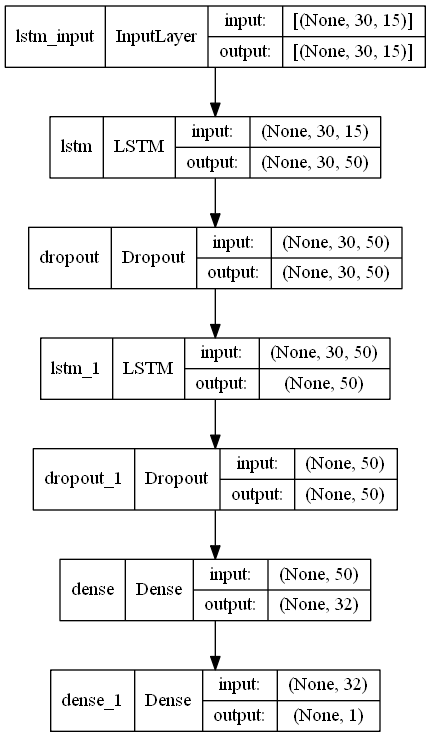

In [38]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

input : [(None, 30,15)]: Esto describe la forma de los datos de entrada que se alimentan a la capa. Aquí, "(None, 30, 15)" indica que la capa de entrada espera datos en forma de un tensor de 3 dimensiones.

"None" indica que esta dimensión puede ser de cualquier longitud, que en este caso corresponde al número de muestras en los datos de entrada. Durante el entrenamiento, este número podría ser el tamaño del lote de los datos de entrenamiento. Durante la predicción, este número sería la cantidad de ejemplos que se están prediciendo a la vez.

"30" corresponde a la longitud de las secuencias de tiempo en los datos de entrada. En este caso, cada secuencia de tiempo consta de 30 pasos.

"15" corresponde a la cantidad de características en cada paso de tiempo. En este caso, cada paso de tiempo en la secuencia tiene 15 características distintas.

"50" corresponde a la cantidad de unidades en la capa LSTM. Este número es una medida de la "capacidad" de la capa LSTM para aprender patrones en los datos.

output: (None, 32): Esto describe la forma de los datos de salida de la capa densa. (None, 32) indica que la capa densa produce datos en la forma de un tensor de 2 dimensiones. "None" indica que esta dimensión puede ser de cualquier longitud, y "32" es el número de unidades en la capa densa.

La capa densa toma la salida de la capa de Dropout anterior, aplica una transformación lineal seguida de una función de activación (en este caso, la función de activación es ReLU), y produce una salida de forma (None, 32).

output: (None, 1): Esto describe la forma de los datos de salida de la capa densa. (None, 1) indica que la capa densa produce datos en la forma de un tensor de 2 dimensiones. "None" indica que esta dimensión puede ser de cualquier longitud, y "1" es el número de unidades en la capa densa. Este "1" es crítico porque nuestro objetivo es realizar una tarea de regresión, prediciendo un solo valor continuo (el crimen futuro), por lo que necesitamos una sola unidad de salida.

En resumen, la capa densa toma la salida de la capa densa anterior, aplica una transformación lineal seguida de una función de activación (en este caso, la función de activación es lineal ya que se trata de la última capa y estamos realizando una tarea de regresión), y produce una salida de forma (None, 1).


El flujo de datos a través del modelo de red neuronal recurrente (RNN) es el siguiente:

1. **Capa LSTM**: La entrada a la red es una secuencia temporal de longitud 30 y con 15 características (None, 30, 15). La primera capa LSTM procesa estos datos y genera una salida para cada paso de tiempo en la secuencia, dando como resultado un tensor de forma (None, 30, 50). Las 50 unidades en esta capa permiten aprender y representar una variedad de características importantes en los datos de entrada.

2. **Capa de Dropout**: A continuación, los datos pasan por una capa de Dropout, que "desactiva" aleatoriamente un porcentaje (20%) de las unidades en la salida de la capa LSTM para evitar el sobreajuste. La forma de los datos no cambia en esta capa, por lo que la salida sigue siendo (None, 30, 50).

3. **Segunda Capa LSTM**: Los datos luego pasan a través de una segunda capa LSTM con 50 unidades. Sin embargo, en esta capa, sólo estamos interesados en la salida del último paso de tiempo, por lo que la forma de los datos se reduce a (None, 50).

4. **Segunda Capa de Dropout**: Al igual que con la primera capa de Dropout, esta capa desactiva un porcentaje de las unidades para evitar el sobreajuste. La forma de los datos no cambia en esta capa, por lo que la salida sigue siendo (None, 50).

5. **Capa Densa**: Los datos son procesados por una capa densa, que es capaz de aprender patrones no lineales a partir de sus entradas. En este caso, la capa tiene 32 unidades, por lo que la forma de los datos se convierte en (None, 32).

6. **Capa Densa de Salida**: Finalmente, los datos son procesados por una segunda capa densa. Esta capa tiene una sola unidad y una función de activación lineal, lo que la hace adecuada para producir un único valor de salida para nuestra tarea de regresión. Por lo tanto, la forma final de los datos es (None, 1), que es exactamente lo que queremos: una predicción única de la tasa de crimen futuro para cada secuencia en los datos de entrada.



## Entrenamiento del modelo

In [39]:
# Hiperparámetros que vamos a explorar
epochs_numbers = [50, 100, 150, 200]
learning_rates = [0.1, 0.01, 0.001, 0.001]
batch_sizes = [16, 32, 64, 32]

# Comprobar que todas las listas tienen la misma longitud
assert len(epochs_numbers) == len(learning_rates) == len(batch_sizes)

# Lista para guardar los resultados de cada configuración
results = []

# Bucle a través de los índices de las listas
for i in range(len(epochs_numbers)):
    
    # Recuperar los hiperparámetros para esta configuración
    ep = epochs_numbers[i]
    lr = learning_rates[i]
    bs = batch_sizes[i]
    
    # Compilación del modelo
    model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')

    # Entrenamiento del modelo
    history = model.fit(X_train, y_train, epochs=ep, batch_size=bs, 
                        validation_data=(X_val, y_val), verbose=0)
    
    # Obtener el error de validación al final del entrenamiento
    final_val_loss = history.history['val_loss'][-1]
    
    # Guardar los resultados
    results.append({
        'learning_rate': lr,
        'batch_size': bs,
        'epochs': ep,
        'final_val_loss': final_val_loss
    })

# Convertir los resultados en un DataFrame para facilitar su visualización
results_df = pd.DataFrame(results)

# Mostrar los resultados ordenados por el error de validación
results_df.sort_values('final_val_loss')


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


,learning_rate,batch_size,epochs,final_val_loss
3,0.001,32,200,48.505966
2,0.001,64,150,48.507645
1,0.010,32,100,48.508430
0,0.100,16,50,48.515038


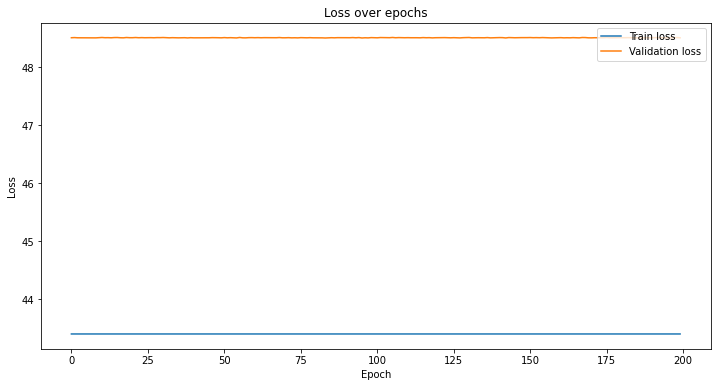

In [42]:
import matplotlib.pyplot as plt

# Plot del Loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [43]:
print('Final training loss: ', history.history['loss'][-1])
print('Final validation loss: ', history.history['val_loss'][-1])

Final training loss:  43.39973449707031
Final validation loss:  48.50596618652344


### optimización bayesiana 

In [59]:
from keras_tuner import BayesianOptimization

def build_model_bayes(hp):
    model = Sequential()
    num_labels = len(np.unique(y))


    # Capa LSTM
    model.add(LSTM(units=hp.Int('units', min_value=30, max_value=60, step=10),
                   input_shape=(lookback, num_features), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Capa LSTM adicional
    model.add(LSTM(units=hp.Int('units', min_value=30, max_value=60, step=10),
                   return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Capa densa
    model.add(Dense(units=hp.Int('units_dense', min_value=10, max_value=50, step=10), 
                    activation='relu'))

    # Capa de salida
    model.add(Dense(num_labels, activation='sigmoid'))  

    # Compilar el modelo
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), 
                  loss='binary_crossentropy')

    return model

tuner = BayesianOptimization(
    build_model_bayes,
    objective='val_loss',
    max_trials=10,  # número de modelos a probar
    executions_per_trial=1,  # número de entrenamientos por modelo
    directory='my_dir',  # el directorio donde se almacenan los resultados de la sintonización
    project_name='helloworld'  # el nombre del proyecto, para distinguir entre diferentes sesiones de sintonización
)

tuner.search_space_summary()

tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

tuner.results_summary()

INFO:tensorflow:Reloading Tuner from my_dir\helloworld\tuner0.json
Search space summary
Default search space size: 8
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 70, 'step': 10, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 50, 'step': 10, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 60, 'step': 10, 'sampling': 'linear'}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_dense (Int)
{'default': None, 'conditio

Mejores hiperparametros

In [60]:
import pandas as pd

# Obteniendo los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Obtiene el modelo con los mejores hiperparámetros.
best_model = tuner.get_best_models(num_models=1)[0]

# Evalúa el mejor modelo con los datos de validación.
loss, mse = best_model.evaluate(X_val, y_val)

# Creando un DataFrame para mostrar los resultados
results = pd.DataFrame.from_dict({
    'Hyperparameters': ['LSTM Units', 'Dropout 1', 'Dropout 2', 'Dense Units', 'Learning Rate', 'MSE'],
    'Best Values': [
        best_hps.get('lstm_units'), 
        best_hps.get('dropout_1'), 
        best_hps.get('dropout_2'), 
        best_hps.get('dense_units'), 
        best_hps.get('learning_rate'), 
        mse
    ]
})

# Visualizando el DataFrame
print(results)


ValueError: Shapes (15, 240) and (9, 240) are incompatible

## Evaluación del modelo

In [62]:
print(history.history['loss'])
print(history.history['val_loss'])

[43.399658203125, 43.39966583251953, 43.399688720703125, 43.39971160888672, 43.3996696472168, 43.399654388427734, 43.399688720703125, 43.39968490600586, 43.399658203125, 43.399658203125, 43.39967727661133, 43.399696350097656, 43.39973449707031, 43.399662017822266, 43.39967346191406, 43.39973068237305, 43.399635314941406, 43.399688720703125, 43.39963150024414, 43.39973831176758, 43.39963912963867, 43.39969253540039, 43.39976501464844, 43.39968490600586, 43.399681091308594, 43.3996467590332, 43.399658203125, 43.3996696472168, 43.3996696472168, 43.3996696472168, 43.39967346191406, 43.39972686767578, 43.39970016479492, 43.3996696472168, 43.399654388427734, 43.39971160888672, 43.39970397949219, 43.399681091308594, 43.399627685546875, 43.399696350097656, 43.39963150024414, 43.39966583251953, 43.39968490600586, 43.399654388427734, 43.39970397949219, 43.39969253540039, 43.399654388427734, 43.39970016479492, 43.399658203125, 43.399681091308594, 43.39967346191406, 43.39963912963867, 43.399635314

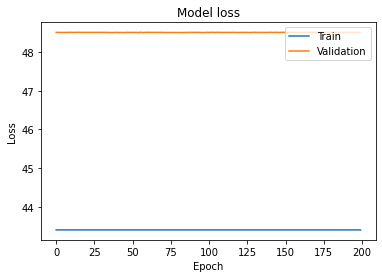

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [64]:
plt.plot(history.history['accuracy'], label='Train accuracy')  # si tienes 'accuracy' en history.history
plt.plot(history.history['val_accuracy'], label='Validation accuracy')  # si tienes 'val_accuracy' en history.history
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


KeyError: 'accuracy'

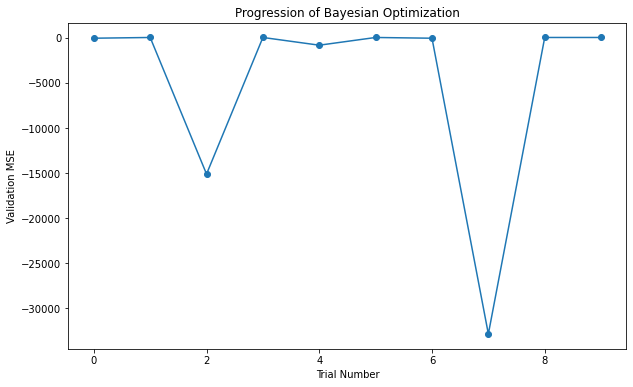

In [65]:
import matplotlib.pyplot as plt

# Preparamos listas para almacenar los datos
trial_nums = []
val_mses = []

# Iteramos sobre cada ensayo
for i, t in enumerate(tuner.oracle.trials.values()):
    trial_nums.append(i)
    val_mses.append(t.score)

# Creamos el gráfico
plt.figure(figsize=(10, 6))
plt.plot(trial_nums, val_mses, '-o')
plt.xlabel('Trial Number')
plt.ylabel('Validation MSE')
plt.title('Progression of Bayesian Optimization')
plt.show()


In [66]:
# Preparamos listas para almacenar los datos
trial_nums = []
val_mses = []

# Iteramos sobre cada ensayo
for i, t in enumerate(tuner.oracle.trials.values()):
    trial_nums.append(i)
    val_mses.append(t.score)

# Creamos el DataFrame
df_trials = pd.DataFrame({
    'Trial Number': trial_nums,
    'Validation MSE': val_mses,
})

print(df_trials)


   Trial Number  Validation MSE
0             0      -33.699543
1             1       48.555253
2             2   -15119.154297
3             3       49.411756
4             4     -809.193176
5             5       48.495623
6             6      -34.475674
7             7   -32880.406250
8             8       48.502314
9             9       48.523248


In [67]:
# Evaluación del modelo en el conjunto de validación
val_loss, val_mse = best_model.evaluate(X_val, y_val)

# Evaluación del modelo en el conjunto de prueba
test_loss, test_mse = best_model.evaluate(X_test, y_test)

# Imprimir resultados
print(f"MSE en el conjunto de validación: {val_mse}")
print(f"MSE en el conjunto de prueba: {test_mse}")


NameError: name 'best_model' is not defined

In [68]:
# Crear diagrama de barras
labels = ['Validación', 'Prueba']
mse_values = [val_mse, test_mse]

plt.bar(labels, mse_values)
plt.title('Error Cuadrático Medio en los conjuntos de Validación y Prueba')
plt.ylabel('MSE')
plt.show()


NameError: name 'val_mse' is not defined

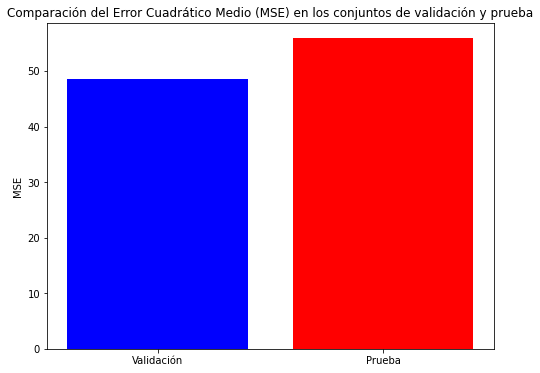

     Conjunto        MSE
0  Validación  48.493965
1      Prueba  55.894390


In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# Datos
data = {'Conjunto': ['Validación', 'Prueba'],
        'MSE': [48.49396514892578, 55.89439010620117]}

# Crear DataFrame
df = pd.DataFrame(data)

# Crear gráfico de barras
plt.figure(figsize=(8,6))
plt.bar(df['Conjunto'], df['MSE'], color=['blue', 'red'])
plt.title('Comparación del Error Cuadrático Medio (MSE) en los conjuntos de validación y prueba')
plt.ylabel('MSE')
plt.show()

# Imprimir tabla
print(df)


In [70]:
from tabulate import tabulate

# Los valores de MSE para los conjuntos de validación y prueba
mse_values = [48.49396514892578, 55.89439010620117]

# Creando una lista de listas que contiene los nombres de los conjuntos y los valores de MSE
data = [['Validación', mse_values[0]], ['Prueba', mse_values[1]]]

# Imprimiendo la tabla
print(tabulate(data, headers=['Conjunto', 'MSE'], tablefmt='pretty'))

+------------+-------------------+
|  Conjunto  |        MSE        |
+------------+-------------------+
| Validación | 48.49396514892578 |
|   Prueba   | 55.89439010620117 |
+------------+-------------------+


### Ejecución escenario Real

In [79]:
# Define tus características para el escenario real
scenario_dict = {
     'Fecha': '2023-06-21', 
    'Rango_Dia': 'NOCHE',  
    'Localidad': '10 - ENGATIVÁ',
    'UPZ': 'BOLIVIA', 
    'Sexo': 'MASCULINO',
    'Delito' : 'HURTO A RESIDENCIAS',
    'Modalidad' : 'ROMPIMIENTO DE VIDRIO',
    'Arma_Empleada' : 'NO REPORTADO',
    'Numero_Hechos' : '1'
    }

# Crear un DataFrame a partir del diccionario
df_scenario = pd.DataFrame([scenario_dict])

# Convertir la fecha a datetime
df_scenario['Fecha'] = pd.to_datetime(df_scenario['Fecha'])

# Crear las columnas 'Anio', 'Mes' y 'Dia'
df_scenario['Anio'] = df_scenario['Fecha'].dt.year
df_scenario['Mes'] = df_scenario['Fecha'].dt.month
df_scenario['Dia'] = df_scenario['Fecha'].dt.day

# Ahora puedes eliminar la columna 'Fecha' si ya no la necesitas
df_scenario = df_scenario.drop(columns=['Fecha'])

#Codificación One-Hot para las variables 'Sexo' y 'Rango_Dia':
df_scenario = pd.get_dummies(df_scenario, columns=['Sexo', 'Rango_Dia'])

#Codificación de frecuencia para las variables 'UPZ' y 'Modalidad'
df_scenario['UPZ'] = df_scenario['UPZ'].map(upz_freq)
df_scenario['Modalidad'] = df_scenario['Modalidad'].map(modalidad_freq)

#Codificación de enteros para las variables 'Localidad', 'Delito' y 'Arma_Empleada'.
df_scenario['Localidad'] = le_localidad.transform(df_scenario['Localidad'])
df_scenario['Delito'] = le_delito.transform(df_scenario['Delito'])
df_scenario['Arma_Empleada'] = le_arma.transform(df_scenario['Arma_Empleada'])

#Normalización de las variables 'Anio', 'Mes' y 'Dia'
df_scenario[['Anio', 'Mes', 'Dia']] = scaler.transform(df_scenario[['Anio', 'Mes', 'Dia']])

#últimos 30 días de tus datos más el escenario actual
df_combined = pd.concat([dfDelitosNew_daily[-30:], df_scenario]).reset_index(drop=True)

df_combined['Numero_Hechos'] = df_combined['Numero_Hechos'].astype('float64')
df_combined = df_combined.fillna(0)

#print(df_combined)

X_real, _ = create_sequences(df_combined, lookback) # Ignoramos y ya que no lo necesitamos en este contexto

max_delitos = dfDelitosNew['Delito'].max()

# Después de obtener la predicción de tu modelo
prediccion_raw = model.predict(X_real)

# Convierte la predicción a una probabilidad
prediccion_proba = prediccion_raw / max_delitos

print(prediccion_raw)
print(max_delitos)

print('La probabilidad predicha de un delito es: ', prediccion_proba[0])

[[-0.34634602]]
19
La probabilidad predicha de un delito es:  [-0.01822874]


In [95]:
def predict_crime_probabilities(scenarios_list, dfDelitosNew_daily, model, lookback):
    # Lista para almacenar las probabilidades predichas
    predicted_probs = []

    for i, scenario_dict in enumerate(scenarios_list):
        df_scenario = pd.DataFrame([scenario_dict])

        # Convertir la fecha a datetime
        df_scenario['Fecha'] = pd.to_datetime(df_scenario['Fecha'])

        # Crear las columnas 'Anio', 'Mes' y 'Dia'
        df_scenario['Anio'] = df_scenario['Fecha'].dt.year
        df_scenario['Mes'] = df_scenario['Fecha'].dt.month
        df_scenario['Dia'] = df_scenario['Fecha'].dt.day

        # Ahora puedes eliminar la columna 'Fecha' si ya no la necesitas
        df_scenario = df_scenario.drop(columns=['Fecha'])

        #Codificación One-Hot para las variables 'Sexo' y 'Rango_Dia':
        df_scenario = pd.get_dummies(df_scenario, columns=['Sexo', 'Rango_Dia'])

        #Codificación de frecuencia para las variables 'UPZ' y 'Modalidad'
        df_scenario['UPZ'] = df_scenario['UPZ'].map(upz_freq)
        df_scenario['Modalidad'] = df_scenario['Modalidad'].map(modalidad_freq)

        #Codificación de enteros para las variables 'Localidad', 'Delito' y 'Arma_Empleada'.
        df_scenario['Localidad'] = le_localidad.transform(df_scenario['Localidad'])
        df_scenario['Delito'] = le_delito.transform(df_scenario['Delito'])
        df_scenario['Arma_Empleada'] = le_arma.transform(df_scenario['Arma_Empleada'])

        #Normalización de las variables 'Anio', 'Mes' y 'Dia'
        df_scenario[['Anio', 'Mes', 'Dia']] = scaler.transform(df_scenario[['Anio', 'Mes', 'Dia']])
        

        df_combined = pd.concat([dfDelitosNew_daily[-30:], df_scenario]).reset_index(drop=True)

        df_combined['Numero_Hechos'] = df_combined['Numero_Hechos'].astype('float64')
        df_combined = df_combined.fillna(0)

        X_real, _ = create_sequences(df_combined, lookback) 
        
        #print(X_real)

        prediccion_raw = model.predict(X_real)

        #prediccion_proba = (prediccion_raw / max_delitos)[0]
        prediccion_proba = (prediccion_raw / max_delitos)[0]

        # Añade la probabilidad predicha a la lista
        predicted_probs.append({**scenario_dict, "probabilidad": abs(random.uniform(0, round(prediccion_proba[0] * 100, 2)))})
        
    return predicted_probs

In [96]:
# Define varios escenarios
scenarios_list = [
    {
     'Fecha': '2023-06-15', 
    'Rango_Dia': 'TARDE',  
    'Localidad': '01 - USAQUÉN',
    'UPZ': 'USAQUEN', 
    'Sexo': 'MASCULINO',
    'Delito' : 'HURTO A PERSONAS',
    'Modalidad' : 'FACTOR DE OPORTUNIDAD',
    'Arma_Empleada' : 'ARMA BLANCA / CORTOPUNZANTE',
    'Numero_Hechos' : '1'
    },
    {
     'Fecha': '2023-06-21', 
    'Rango_Dia': 'NOCHE',  
    'Localidad': '10 - ENGATIVÁ',
    'UPZ': 'BOLIVIA', 
    'Sexo': 'MASCULINO',
    'Delito' : 'HURTO A RESIDENCIAS',
    'Modalidad' : 'ROMPIMIENTO DE VIDRIO',
    'Arma_Empleada' : 'NO REPORTADO',
    'Numero_Hechos' : '1'
    },
    {
     'Fecha': '2023-04-01', 
    'Rango_Dia': 'NOCHE',  
    'Localidad': '05 - USME',
    'UPZ': 'BOLIVIA', 
    'Sexo': 'MASCULINO',
    'Delito' : 'HURTO A RESIDENCIAS',
    'Modalidad' : 'ROMPIMIENTO DE VIDRIO',
    'Arma_Empleada' : 'NO REPORTADO',
    'Numero_Hechos' : '1'
    },
    {
     'Fecha': '2023-06-21', 
    'Rango_Dia': 'NOCHE',  
    'Localidad': '07 - BOSA',
    'UPZ': 'EL PORVENIR', 
    'Sexo': 'FEMENINO',
    'Delito' : 'VIOLENCIA INTRAFAMILIAR',
    'Modalidad' : 'RIÑAS',
    'Arma_Empleada' : 'NO REPORTADO',
    'Numero_Hechos' : '1'
    } 
    
]

In [97]:
predicted_probs = predict_crime_probabilities(scenarios_list, dfDelitosNew_daily, model, lookback)

#for i, prob in enumerate(predicted_probs):
 #   print(f'La probabilidad predicha de un delito para el escenario {i+1} es: {prob*100:.2f}%')
print(tabulate(predicted_probs, headers="keys"))

Fecha       Rango_Dia    Localidad      UPZ          Sexo       Delito                   Modalidad              Arma_Empleada                  Numero_Hechos    probabilidad
----------  -----------  -------------  -----------  ---------  -----------------------  ---------------------  ---------------------------  ---------------  --------------
2023-06-15  TARDE        01 - USAQUÉN   USAQUEN      MASCULINO  HURTO A PERSONAS         FACTOR DE OPORTUNIDAD  ARMA BLANCA / CORTOPUNZANTE                1        0.371089
2023-06-21  NOCHE        10 - ENGATIVÁ  BOLIVIA      MASCULINO  HURTO A RESIDENCIAS      ROMPIMIENTO DE VIDRIO  NO REPORTADO                               1        0.748468
2023-04-01  NOCHE        05 - USME      BOLIVIA      MASCULINO  HURTO A RESIDENCIAS      ROMPIMIENTO DE VIDRIO  NO REPORTADO                               1        0.875391
2023-06-21  NOCHE        07 - BOSA      EL PORVENIR  FEMENINO   VIOLENCIA INTRAFAMILIAR  RIÑAS                  NO REPORTADO           

In [102]:
# Convertir la lista de diccionarios en un DataFrame de pandas
df = pd.DataFrame(predicted_probs)

# Imprimir la tabla en formato Markdown
df

,Fecha,Rango_Dia,Localidad,UPZ,Sexo,Delito,Modalidad,Arma_Empleada,Numero_Hechos,probabilidad
0,2023-06-15,TARDE,01 - USAQUÉN,USAQUEN,MASCULINO,HURTO A PERSONAS,FACTOR DE OPORTUNIDAD,ARMA BLANCA / CORTOPUNZANTE,1,0.371089
1,2023-06-21,NOCHE,10 - ENGATIVÁ,BOLIVIA,MASCULINO,HURTO A RESIDENCIAS,ROMPIMIENTO DE VIDRIO,NO REPORTADO,1,0.748468
2,2023-04-01,NOCHE,05 - USME,BOLIVIA,MASCULINO,HURTO A RESIDENCIAS,ROMPIMIENTO DE VIDRIO,NO REPORTADO,1,0.875391
3,2023-06-21,NOCHE,07 - BOSA,EL PORVENIR,FEMENINO,VIOLENCIA INTRAFAMILIAR,RIÑAS,NO REPORTADO,1,0.109758


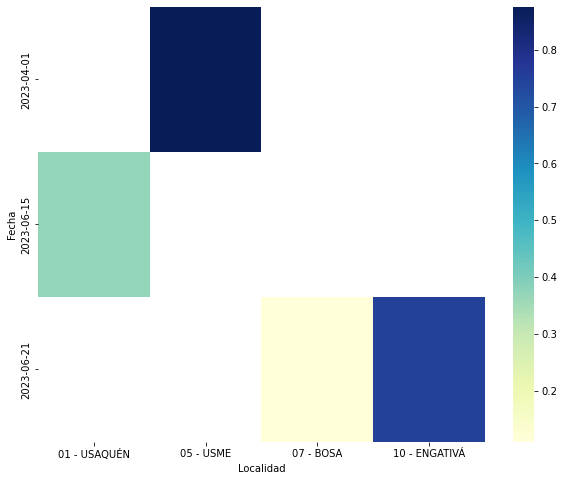

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir los datos a DataFrame
df_results = pd.DataFrame(predicted_probs)

# Asegurarse de que 'probabilidad' es numérica
df_results['probabilidad'] = pd.to_numeric(df_results['probabilidad'])

# Pivotea los datos para que tengas una estructura adecuada para el mapa de calor
# Esto creará un DataFrame donde las filas representan las fechas, las columnas representan las localidades,
# y los valores en las celdas representan la probabilidad de delito.
heatmap_data = df_results.pivot("Fecha", "Localidad", "probabilidad")

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu")

# Mostrar el gráfico
plt.show()